In [2]:
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import tensorflow as tf

In [3]:
path = Path('datasets/ridership/CTA_-_Ridership_-_Daily_Boarding_Totals_20240728.csv')
df = pd.read_csv(path, parse_dates=['service_date'])
df.columns = ['data', 'typ_dnia', 'autobus', 'kolej', 'suma']
df = df.sort_values('data').set_index('data')
df = df.drop('suma', axis=1)
df = df.drop_duplicates()

In [3]:
df.head()

,typ_dnia,autobus,kolej
data,,,
2001-01-01,U,297192,126455
2001-01-02,W,780827,501952
2001-01-03,W,824923,536432
2001-01-04,W,870021,550011
2001-01-05,W,890426,557917


In [14]:
df['typ_dnia'].unique

<bound method Series.unique of data
2001-01-01    U
2001-01-02    W
2001-01-03    W
2001-01-04    W
2001-01-05    W
             ..
2024-03-27    W
2024-03-28    W
2024-03-29    W
2024-03-30    A
2024-03-31    U
Name: typ_dnia, Length: 8491, dtype: object>

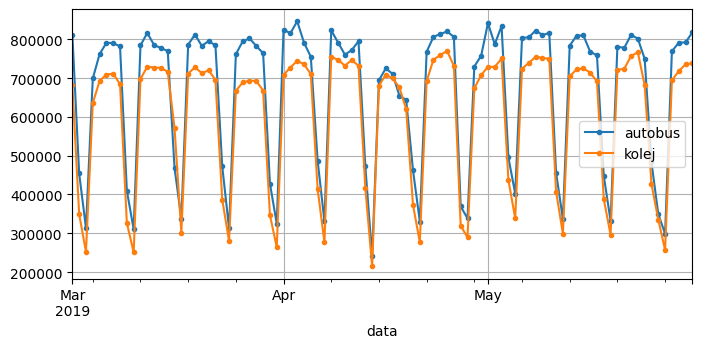

In [5]:
df['2019-03':'2019-05'].plot(grid=True, marker='.', figsize=(8, 3.5))
plt.show()

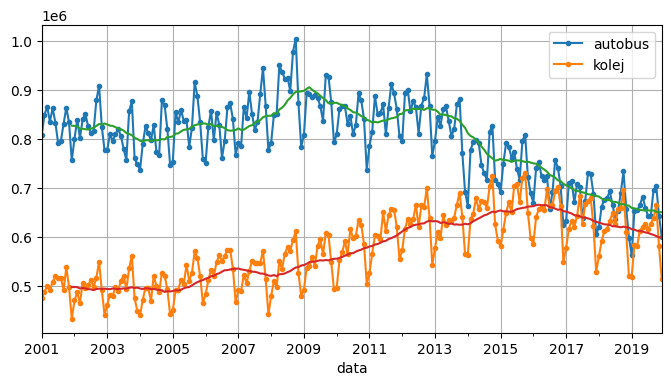

In [15]:
df_num = df.select_dtypes(include='number') # pick numeric data (using df with day type raises TypeError)
period = slice('2001', '2019')
df_monthly = df_num.resample('ME').mean() # each month mean
rolling_average_12_months = df_monthly[period].rolling(window=12).mean()
fig, ax = plt.subplots(figsize=(8,4))
df_monthly[period].plot(ax=ax, marker='.')
rolling_average_12_months.plot(ax=ax, grid=True, legend=False)
plt.show()

In [4]:
# sample timeseries data processing using timeseries_dataset_from_array
sample_series = [0, 1, 2, 3, 4, 5]
sample_dataset = tf.keras.utils.timeseries_dataset_from_array(sample_series, targets=sample_series[3:], sequence_length=3, batch_size=2)
list(sample_dataset)

2024-07-29 12:53:01.783321: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


[(<tf.Tensor: shape=(2, 3), dtype=int32, numpy=
  array([[0, 1, 2],
         [1, 2, 3]], dtype=int32)>,
  <tf.Tensor: shape=(2,), dtype=int32, numpy=array([3, 4], dtype=int32)>),
 (<tf.Tensor: shape=(1, 3), dtype=int32, numpy=array([[2, 3, 4]], dtype=int32)>,
  <tf.Tensor: shape=(1,), dtype=int32, numpy=array([5], dtype=int32)>)]

In [5]:
# using dataset window
for window_dataset in tf.data.Dataset.range(6).window(4, shift=1):
    for element in window_dataset:
        print(f'{element}', end=' ')
    print()

0 1 2 3 
1 2 3 4 
2 3 4 5 
3 4 5 
4 5 
5 


2024-07-29 13:01:58.312865: W tensorflow/core/framework/dataset.cc:993] Input of Window will not be optimized because the dataset does not implement the AsGraphDefInternal() method needed to apply optimizations.
2024-07-29 13:01:58.324525: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
2024-07-29 13:01:58.339847: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [6]:
dataset = tf.data.Dataset.range(6).window(4, shift=1, drop_remainder=True)
dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(4))
for window_tensor in dataset:
    print(f'{window_tensor}')

[0 1 2 3]
[1 2 3 4]
[2 3 4 5]


In [4]:
# getting tensors from dataset
def to_windows(dataset, length):
    dataset = dataset.window(length, shift=1, drop_remainder=True)
    return dataset.flat_map(lambda window_ds: window_ds.batch(length))

In [8]:
dataset = to_windows(tf.data.Dataset.range(6), 4)
dataset = dataset.map(lambda window: (window[:-1], window[-1:]))
list(dataset.batch(2))

[(<tf.Tensor: shape=(2, 3), dtype=int64, numpy=
  array([[0, 1, 2],
         [1, 2, 3]])>,
  <tf.Tensor: shape=(2, 1), dtype=int64, numpy=
  array([[3],
         [4]])>),
 (<tf.Tensor: shape=(1, 3), dtype=int64, numpy=array([[2, 3, 4]])>,
  <tf.Tensor: shape=(1, 1), dtype=int64, numpy=array([[5]])>)]

In [10]:
print(df['kolej'].min())
df['kolej'].max()

23544


1146516

In [5]:
# rail passenger data division and scaling to 0-1
rail_train = df['kolej']['2016-01':'2018-12'] / 2e6
rail_valid = df['kolej']['2019-01':'2019-05'] / 2e6
rail_test = df['kolej']['2019-06':] / 2e6

In [7]:
# 
seq_length = 56
train_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_train.to_numpy(),
    targets=rail_train[seq_length:],
    sequence_length=seq_length,
    batch_size=32,
    shuffle=True,
    seed=42
)
valid_ds = tf.keras.utils.timeseries_dataset_from_array(
    rail_valid.to_numpy(),
    targets=rail_valid[seq_length:],
    sequence_length=seq_length,
    batch_size=32
)

In [8]:
def fit_and_evaluate(model, train_set, valid_set, learning_rate, epochs=500):
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor='val_mae',
        patience=50,
        restore_best_weights=True
    )
    opt = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9)
    model.compile(loss=tf.keras.losses.Huber(), optimizer=opt, metrics=['mae'])
    history = model.fit(train_set, validation_data=valid_set, epochs=epochs, callbacks=[early_stopping_callback])
    valid_loss, valid_mae = model.evaluate(valid_set)
    return valid_mae * 2e6

In [9]:
# standard linear model
tf.random.set_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Dense(1, input_shape=[seq_length])
])

/home/kvu/Projects/ml_tests/venv/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [10]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500


I0000 00:00:1722332741.734481   32140 service.cc:146] XLA service 0x7f5dd0004d40 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1722332741.734510   32140 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-07-30 11:45:41.791345: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-07-30 11:45:42.034227: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8907


24/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0483 - mae: 0.2634

I0000 00:00:1722332742.501244   32140 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.0410 - mae: 0.2365 - val_loss: 0.0071 - val_mae: 0.0925
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0049 - mae: 0.0771 - val_loss: 0.0034 - val_mae: 0.0625
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0031 - mae: 0.0590 - val_loss: 0.0028 - val_mae: 0.0559
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0028 - mae: 0.0541 - val_loss: 0.0024 - val_mae: 0.0520
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0025 - mae: 0.0519 - val_loss: 0.0026 - val_mae: 0.0539
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0026 - mae: 0.0525 - val_loss: 0.0022 - val_mae: 0.0487
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0027 - mae: 0.0534 - val_loss: 0.0020 - val_mae: 0.0474
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0024 - mae: 0.0502 - val_loss: 0.0020 - val_mae: 0.0467
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0024 - mae: 0.

38868.02867054939

In [11]:
# simple recurrent nn
# input shape None for any length time series, 1 for dimension (only rail data)
# tanh - default activation function
model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

/home/kvu/Projects/ml_tests/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [12]:
fit_and_evaluate(model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0321 - mae: 0.2101 - val_loss: 0.0051 - val_mae: 0.0825
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0052 - mae: 0.0884 - val_loss: 0.0051 - val_mae: 0.0762
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0047 - mae: 0.0814 - val_loss: 0.0047 - val_mae: 0.0819
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 26ms/step - loss: 0.0045 - mae: 0.0825 - val_loss: 0.0047 - val_mae: 0.0752
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0044 - mae: 0.0796 - val_loss: 0.0045 - val_mae: 0.0815
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - loss: 0.0043 - mae: 0.0797 - val_loss: 0.0044 - val_mae: 0.0782
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - mae: 0.0812 - val_loss: 0.0043 - val_mae: 0.0803
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0041 - mae: 0.0796 - val_loss: 0.0043 - val_mae: 0.0739
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - lo

119739.79324102402

In [13]:
# recurrent nn with more neurons
univar_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, input_shape=[None, 1]),
    tf.keras.layers.Dense(1)
])

/home/kvu/Projects/ml_tests/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
fit_and_evaluate(univar_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 84ms/step - loss: 0.0226 - mae: 0.1618 - val_loss: 0.0016 - val_mae: 0.0443
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 0.0015 - mae: 0.0391 - val_loss: 7.7135e-04 - val_mae: 0.0277
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step - loss: 0.0011 - mae: 0.0309 - val_loss: 5.9235e-04 - val_mae: 0.0230
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 59ms/step - loss: 9.0106e-04 - mae: 0.0267 - val_loss: 5.6121e-04 - val_mae: 0.0220
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 56ms/step - loss: 8.1712e-04 - mae: 0.0257 - val_loss: 5.0197e-04 - val_mae: 0.0193
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 55ms/step - loss: 8.1189e-04 - mae: 0.0248 - val_loss: 5.2087e-04 - val_mae: 0.0193
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 7.8482e-04 - mae: 0.0241 - val_loss: 5.2992e-04 - val_mae: 0.0194
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 7.6251e-04 - mae: 0.0239 - val_loss: 5.3191e-04 - val_mae: 0.0189
Epoch 9/

31893.257051706314

In [15]:
# deep recurrent nn
# upper rnn layers have to return sequences
deep_model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(32, return_sequences=True, input_shape=[None, 1]),
    tf.keras.layers.SimpleRNN(32, return_sequences=True),
    tf.keras.layers.SimpleRNN(32),
    tf.keras.layers.Dense(1)
])

/home/kvu/Projects/ml_tests/venv/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [16]:
fit_and_evaluate(deep_model, train_ds, valid_ds, learning_rate=0.02)

Epoch 1/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 14s 301ms/step - loss: 0.0816 - mae: 0.2421 - val_loss: 0.0040 - val_mae: 0.0794
Epoch 2/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 168ms/step - loss: 0.0058 - mae: 0.0905 - val_loss: 0.0052 - val_mae: 0.0603
Epoch 3/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 6s 164ms/step - loss: 0.0042 - mae: 0.0793 - val_loss: 0.0042 - val_mae: 0.0610
Epoch 4/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 138ms/step - loss: 0.0043 - mae: 0.0778 - val_loss: 0.0035 - val_mae: 0.0744
Epoch 5/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 136ms/step - loss: 0.0042 - mae: 0.0818 - val_loss: 0.0037 - val_mae: 0.0621
Epoch 6/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 141ms/step - loss: 0.0041 - mae: 0.0779 - val_loss: 0.0033 - val_mae: 0.0689
Epoch 7/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 5s 144ms/step - loss: 0.0038 - mae: 0.0759 - val_loss: 0.0031 - val_mae: 0.0694
Epoch 8/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 117ms/step - loss: 0.0037 - mae: 0.0736 - val_loss: 0.0031 - val_mae: 0.0567
Epoch 9/500
33/33 ━━━━━━━━━━━━━━━━━━━━ 4s 133ms

29533.477500081062